In [60]:
import pandas as pd
import numpy as np
import time
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Let's use up to 20k lines to see how good we get our AI.

In [2]:
READ_LINES = 20000
best_features = ['AddressOfEntryPoint', 'MajorLinkerVersion', 'NumberOfSections', 'PointerToRawData', 'SizeOfCode', 'SizeOfImage', 'SizeOfInitializedData',
                 'SizeOfRawData', 'VirtualAddress', 'section_data_PointerToRawData', 'section_data_SizeOfRawData', 'section_data_VirtualAddress',
                 'section_data_VirtualSize', 'section_idata_PointerToRawData', 'section_idata_VirtualAddress', 'section_idata_VirtualSize',
                 'section_rdata_SizeOfRawData', 'section_rdata_VirtualAddress', 'section_rdata_VirtualSize', 'section_reloc_PointerToRawData',
                 'section_reloc_SizeOfRawData', 'section_reloc_VirtualAddress', 'section_reloc_VirtualSize', 'section_rsrc_PointerToRawData',
                 'section_rsrc_SizeOfRawData', 'section_rsrc_VirtualAddress', 'section_rsrc_VirtualSize', 'section_rsrc_exec', 'section_rsrc_write',
                 'section_text_SizeOfRawData', 'section_text_VirtualSize']
use_columns = best_features + ['hash', 'malicious']
malicious_data = pd.read_csv('/rodata/exercise03/clam_mal.csv', index_col=None, nrows=READ_LINES, usecols=use_columns)
benign_data = pd.read_csv('/rodata/exercise03/clam_benign.csv', index_col=None, nrows=READ_LINES, usecols=use_columns)

Merge malicious and clean data (features), remove sample hashes, and split out classes

In [44]:
learn_data = malicious_data.append(benign_data, ignore_index=True)
learn_data.fillna(0, inplace=True) # fill missing entries from either set with 0
# shuffle data
learn_data = learn_data.sample(frac = 1, random_state=1).reset_index(drop=True)

classes = learn_data['malicious']
del learn_data['malicious']
del learn_data['hash']

/tmp/ipykernel_127293/1716884760.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learn_data = malicious_data.append(benign_data, ignore_index=True)


We start tuning with a single split for now.

In [87]:
models = []


In [102]:
features_train, features_test, classes_train, classes_test = \
model_selection.train_test_split(learn_data, classes, test_size=0.2)

classifier = ensemble.RandomForestClassifier()
classifier.fit(features_train, classes_train)

probabilities = classifier.predict_proba(features_test)

Q: What is the THRESHOLD that gives your wanted results?

In [117]:
THRESHOLD = 0.95
prediction = [1 if (proba_malicious > THRESHOLD) else 0 
              for proba_benign, proba_malicious in probabilities ]
print(metrics.accuracy_score(classes_test, prediction))
print(metrics.confusion_matrix(classes_test, prediction))
print(classification_report(classes_test, prediction))
tn, fp, fn, tp =metrics.confusion_matrix(classes_test, prediction).ravel()
fp_rate = fp/(fp +tn)
print('False Positive rate (FPR) = %.3f' % fp_rate)

0.8782234957020058
[[3658    6]
 [ 929 3085]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3664
           1       1.00      0.77      0.87      4014

    accuracy                           0.88      7678
   macro avg       0.90      0.88      0.88      7678
weighted avg       0.90      0.88      0.88      7678

False Positive rate (FPR) = 0.002


Print Receiver Operating Character (ROC) curve. Determine False Positive rates for different True Positive rates.

In [89]:
models.append(['RF', fp_rate, 0.90])

In [118]:
fp_rate, tp_rate, threshold = metrics.roc_curve(classes_test, 
                                                prediction)
roc_auc = roc_auc_score(classes_test, probabilities[:,1])

Plot this as a curve

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


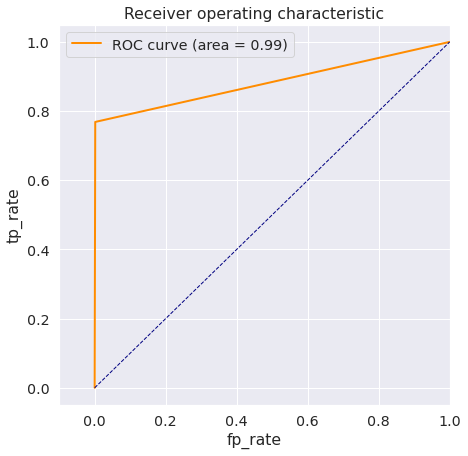

In [119]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
ax = sns.lineplot(fp_rate, tp_rate, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
ax = sns.lineplot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set_xlabel('fp_rate')
ax.set_ylabel('tp_rate')
ax.set_xlim(-0.1,1)
plt.show()

Print this as a table

In [29]:
print(pd.DataFrame({"False Positive rate": fp_rate, 
                        "Detection Rate": tp_rate,
                        "Threshold": threshold}))

     False Positive rate  Detection Rate  Threshold
0               0.000000        0.000000   2.000000
1               0.000828        0.662309   1.000000
2               0.000828        0.662802   0.999706
3               0.000828        0.663296   0.991667
4               0.000828        0.663789   0.991250
..                   ...             ...        ...
304             0.499724        0.998767   0.009167
305             0.500000        0.998767   0.005000
306             0.617826        0.999013   0.004444
307             0.618377        0.999013   0.002000
308             1.000000        1.000000   0.000000

[309 rows x 3 columns]


#### Reduce the number of features using PCA

In [50]:
# Create a PCA that will retain 99% of variance
pca = PCA(n_components=0.99, whiten=True)

# Conduct PCA
#features_pca = pca.fit_transform(features)
features_pca = pca.fit_transform(learn_data)

# Show results
print("Original number of features:", learn_data.shape[1])
print("Reduced number of features:", features_pca.shape[1])

# split the data again
features_train_pca, features_test_pca, classes_train_pca, classes_test_pca = \
model_selection.train_test_split(features_pca, classes, test_size=0.2)

# fit a random forest with the pca features
classifier2 = ensemble.RandomForestClassifier()
classifier2.fit(features_train_pca, classes_train_pca)

prediction2 = classifier2.predict(features_test_pca)
print(metrics.accuracy_score(classes_test_pca, prediction2))
print(metrics.confusion_matrix(classes_test_pca, prediction2))
print(classification_report(classes_test_pca, prediction2))
tn2, fp2, fn2, tp2 =metrics.confusion_matrix(classes_test, prediction2).ravel()
fp_rate2 = fp2/(fp2 +tn2)
print('False Positive rate (FPR) = %.3f' % fp_rate2)


Original number of features: 31
Reduced number of features: 8
0.9258921594165147
[[3395  239]
 [ 330 3714]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3634
           1       0.94      0.92      0.93      4044

    accuracy                           0.93      7678
   macro avg       0.93      0.93      0.93      7678
weighted avg       0.93      0.93      0.93      7678

False Positive rate (FPR) = 0.509


In [90]:
models.append(['RF_PCA', fp_rate2, 0.92])

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


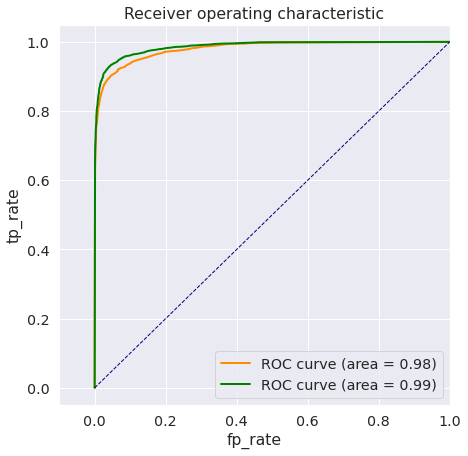

In [94]:
# plot ROC pca randomforest
probabilities2 = classifier2.predict_proba(features_test_pca)
fp_rate2, tp_rate2, threshold2 = metrics.roc_curve(classes_test_pca, 
                                                probabilities2[:,1])
roc_auc2 = roc_auc_score(classes_test_pca, probabilities2[:,1])

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
ax = sns.lineplot(fp_rate2, tp_rate2, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc2)
ax = sns.lineplot(x =fp_rate, y= tp_rate, lw=2, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
ax = sns.lineplot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set_xlabel('fp_rate')
ax.set_ylabel('tp_rate')
ax.set_xlim(-0.1,1)
plt.show()

In [57]:
# cross validation with the models
start = time.time()
scores = model_selection.cross_val_score(classifier, learn_data,
                                         classes, cv = 5)
print('\033[1m Random Forest Model\033[0m')
print(scores)
print("Cross Validation of RF took %.1f seconds" % (time.time()-start))
print("Accuracy: %.3f (+/- %.3f)" % (scores.mean(), scores.std() * 2))

start = time.time()
scores = model_selection.cross_val_score(classifier2, features_pca, classes, cv = 5)

print('\033[1m Random Forest PCA Model\033[0m')                                       
print(scores)
print("Cross Validation of RF_PCA took %.1f seconds" % (time.time()-start))
print("Accuracy: %.3f (+/- %.3f)" % (scores.mean(), scores.std() * 2))


 Random Forest Model
[0.93852566 0.93838739 0.94333724 0.94203465 0.9428162 ]
Cross Validation of RF took 35.4 seconds
Accuracy: 0.941 (+/- 0.004)
 Random Forest PCA Model
[0.92576192 0.9230168  0.92887847 0.92679432 0.92601277]
Cross Validation of RF_PCA took 31.5 seconds
Accuracy: 0.926 (+/- 0.004)


#### Fine tuning the PCA model

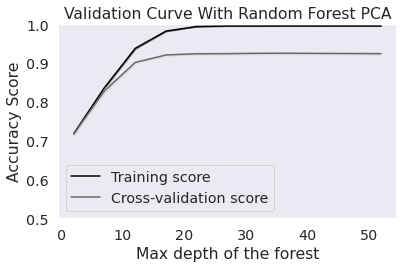

In [64]:
# Try hyperparameters on the dataset: max depth
param_range = np.arange(2, 55, 5)

classifier3 = ensemble.RandomForestClassifier(n_estimators = 50)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    classifier3,
    # Feature matrix
    features_pca,
    # Target vector
    classes,
    # Hyperparameter to examine
    param_name="max_depth",
    # Range of hyperparameter's values
    param_range=param_range,
    # Number of folds
    cv=5,
    # Performance metric
    scoring="accuracy",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest PCA")
plt.xlabel("Max depth of the forest")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.ylim(.50,1)
plt.grid()
plt.show()

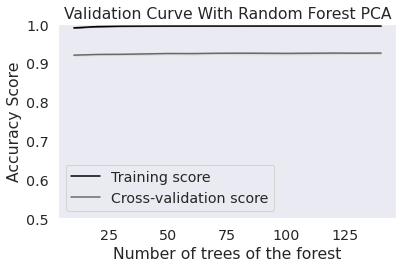

In [66]:
# Try hyperparameters on the dataset: max depth
param_range4 = np.arange(10, 150, 10)

classifier4 = ensemble.RandomForestClassifier(max_depth =30)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    classifier4,
    # Feature matrix
    features_pca,
    # Target vector
    classes,
    # Hyperparameter to examine
    param_name="n_estimators",
    # Range of hyperparameter's values
    param_range=param_range4,
    # Number of folds
    cv=5,
    # Performance metric
    scoring="accuracy",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range4, train_mean, label="Training score", color="black")
plt.plot(param_range4, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range4, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range4, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest PCA")
plt.xlabel("Number of trees of the forest")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.ylim(.50,1)
plt.grid()
plt.show()

In [74]:
np.mean( test_mean)

0.9248461378753252

#### tune the classification threshold

0.9425631674915342
[[3489  175]
 [ 266 3748]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3664
           1       0.96      0.93      0.94      4014

    accuracy                           0.94      7678
   macro avg       0.94      0.94      0.94      7678
weighted avg       0.94      0.94      0.94      7678

0.9424329252409481
[[3530  134]
 [ 308 3706]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3664
           1       0.97      0.92      0.94      4014

    accuracy                           0.94      7678
   macro avg       0.94      0.94      0.94      7678
weighted avg       0.94      0.94      0.94      7678

0.9411305027350872
[[3561  103]
 [ 349 3665]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3664
           1       0.97      0.91      0.94      4014

    accuracy                           0.94 

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.10/site-

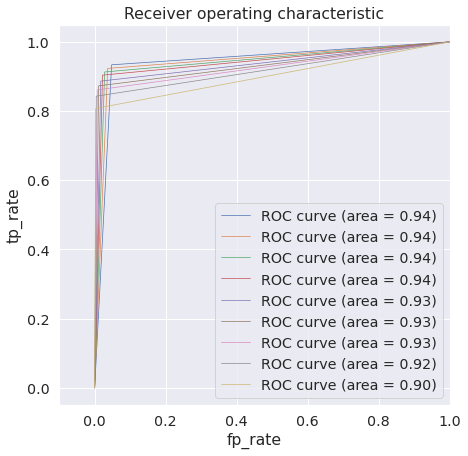

In [126]:
probabilities = classifier.predict_proba(features_test)

predictions = []
fp_rates =[]
tp_rates = []
roc_aucs = []

threshold_range = np.arange (0.5,1,0.05)
for t in threshold_range:
    prediction = [1 if (proba_malicious > t) else 0 
              for proba_benign, proba_malicious in probabilities ]
    predictions.append(np.array(prediction))
    print(metrics.accuracy_score(classes_test, prediction))
    print(metrics.confusion_matrix(classes_test, prediction))
    print(classification_report(classes_test, prediction))
    
    fp_rate, tp_rate, threshold = metrics.roc_curve(classes_test, 
                                                prediction)
    roc_auc = roc_auc_score(classes_test, prediction)
    fp_rates.append(np.array(fp_rate))
    tp_rates.append(np.array(tp_rate))
    roc_aucs.append(np.array(roc_auc))

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
for t in np.arange (0, len(threshold_range)-1):
    ax = sns.lineplot(fp_rates[t], tp_rates[t], lw=0.7, label='ROC curve (area = %0.2f)' % roc_aucs[t])

ax.set_title('Receiver operating characteristic')
ax.set_xlabel('fp_rate')
ax.set_ylabel('tp_rate')
ax.set_xlim(-0.1,1)
plt.show()